### Data Setup for Models

In [21]:
# Connect to SQLite database
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"
con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [22]:
# Load Data
import pandas as pd
import numpy as np

df = pd.read_sql_query("SELECT * FROM ACGR", con)

# Count missing values for each column
df.replace('*', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

### Data Summary

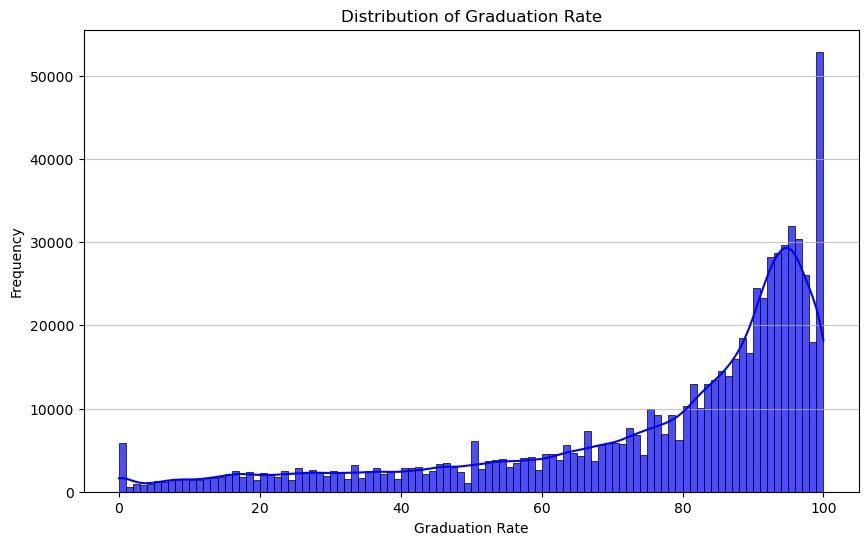

Mean Graduation Rate: 76.66736629192883


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['RegHSDiplomaRate'].dropna(), bins=100, kde=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Graduation Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Graduation Rate")
plt.grid(axis='y', alpha=0.75)
plt.show()


mean_graduation_rate = df['RegHSDiplomaRate'].mean()
print(f"Mean Graduation Rate: {mean_graduation_rate}")  

### Lasso Regression with RegHSDiplomaRate as target

Number of features after encoding: 27

StillEnrolledRate: -10.353303322371618
DistrictCode: 4.033679732565033
UniReqsPercent: 3.987306210291859
Dropout: -3.7012698043477577
SPEDRate: -2.757652120461043
OtherRate: -2.56168193891638
MeritRate: 1.696218859967412
RegHSDiploma: 1.517480904880737
AdultEdRate: -0.9310985136955607
ExemptionRate: -0.8891414622649807
BiliteracyRate: 0.5482682762004877
GEDRate: -0.45962336984986474
Exemption: 0.3986585817630682
CPPRate: -0.20664969835592037
CountyCode: -0.0034011066262392728
AdultEd: -0.0
Biliteracy: 0.0
CPP: -0.0
CohortStudents: 0.0
GED: -0.0
Merit: 0.0
Other: 0.0
SPED: 0.0
SchoolCode: 0.0
StillEnrolled: -0.0
UniReqs: 0.0
cdsCode: -0.0


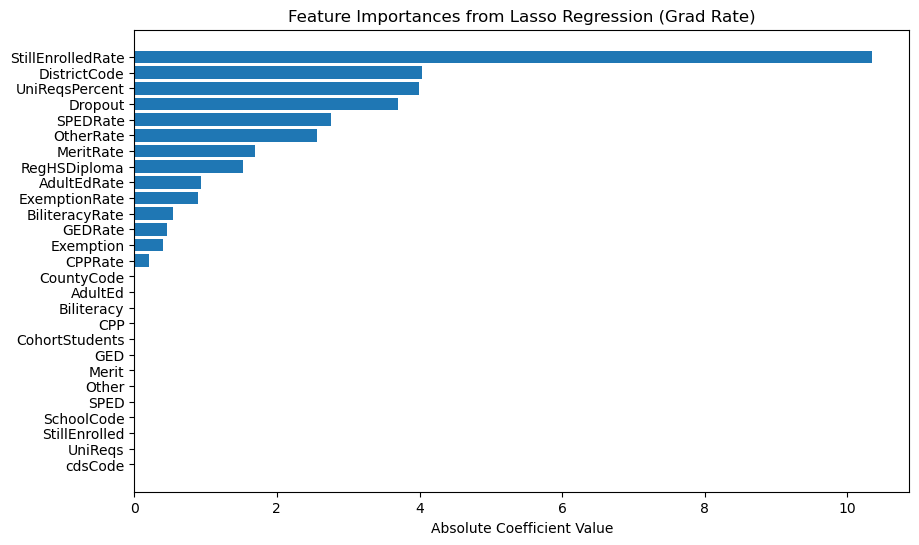

In [24]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Convert categorical variables to dummy variables
categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define the target variable
target_column = 'RegHSDiplomaRate'

# Convert the target column to numeric, coercing errors to NaN
df[target_column] = pd.to_numeric(df[target_column], errors='coerce')


# Define numeric features
numeric_features = df.columns.difference(categorical_cols).tolist()

# Drop rows with NaN values in the target column or features
df_encoded.dropna(subset=numeric_features + [target_column], inplace=True)

# Drop rows with NaN values in the categorical columns after encoding
df_encoded.dropna(inplace=True)

numeric_features = df_encoded.columns.difference(categorical_cols + [target_column, "DropoutRate"]).tolist()

X = df_encoded[numeric_features]
y = df_encoded[target_column]


print(f"Number of features after encoding: {X.shape[1]}")


# Create a pipeline with scaling and Lasso with cross-validation
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit the model
pipe.fit(X, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_
# Print features and coefficients sorted by absolute value of coefficient (highest first)
coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in sorted_pairs], [abs(f[1]) for f in sorted_pairs])
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importances from Lasso Regression (Grad Rate)")
plt.gca().invert_yaxis()
plt.show()


### Lasso Model Validation

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)
print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.6624255538417105
Mean Squared Error: 148.06734750618105
Root Mean Squared Error: 12.168292711230325
Best alpha value: 0.01366823639488446


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.281e+05, tolerance: 1.713e+03
  model = cd_fast.enet_coordinate_descent(


### Lasso Residuals and Actual vs. Predicted

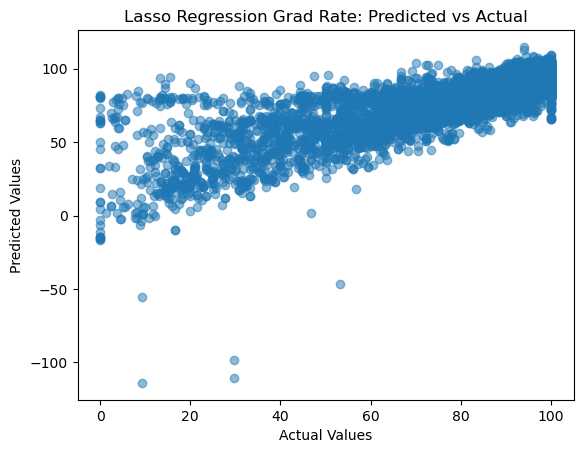

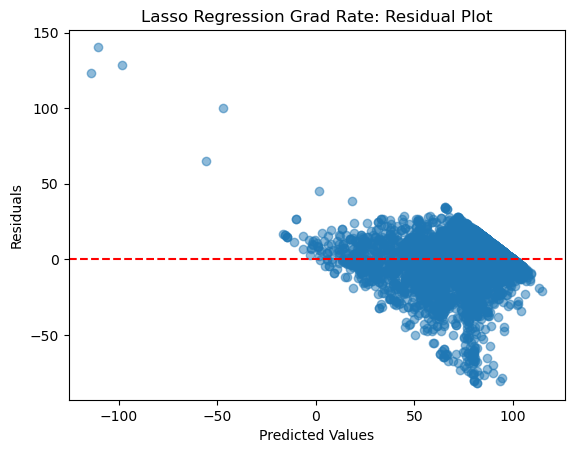

In [26]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Grad Rate: Predicted vs Actual")
plt.show()

# Convert y_test to numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')

# Calculate residuals
residuals = y_test_numeric - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression Grad Rate: Residual Plot")
plt.show()

### XGBoost Model for Graduation Rate

Feature ranking:
1. StillEnrolledRate (0.4572717547416687)
2. UniReqs (0.12131521105766296)
3. RegHSDiploma (0.1178332045674324)
4. Dropout (0.08197988569736481)
5. UniReqsPercent (0.04700053855776787)
6. DistrictCode (0.023256216198205948)
7. Biliteracy (0.02166176773607731)
8. SPEDRate (0.02047773264348507)
9. OtherRate (0.017989913001656532)
10. CohortStudents (0.01607331819832325)
11. Merit (0.015294695273041725)
12. MeritRate (0.014994042925536633)
13. GED (0.009767684154212475)
14. SPED (0.0060379463247954845)
15. StillEnrolled (0.003891898086294532)
16. GEDRate (0.0038012221921235323)
17. AdultEdRate (0.0034452916588634253)
18. Other (0.0034155482426285744)
19. CountyCode (0.0034100140910595655)
20. CPPRate (0.0030982401221990585)
21. AdultEd (0.001935774926096201)
22. CPP (0.0015205541858449578)
23. cdsCode (0.0014028737787157297)
24. ExemptionRate (0.0013783224858343601)
25. Exemption (0.0008473938796669245)
26. BiliteracyRate (0.000635156815405935)
27. SchoolCode (0.000263768

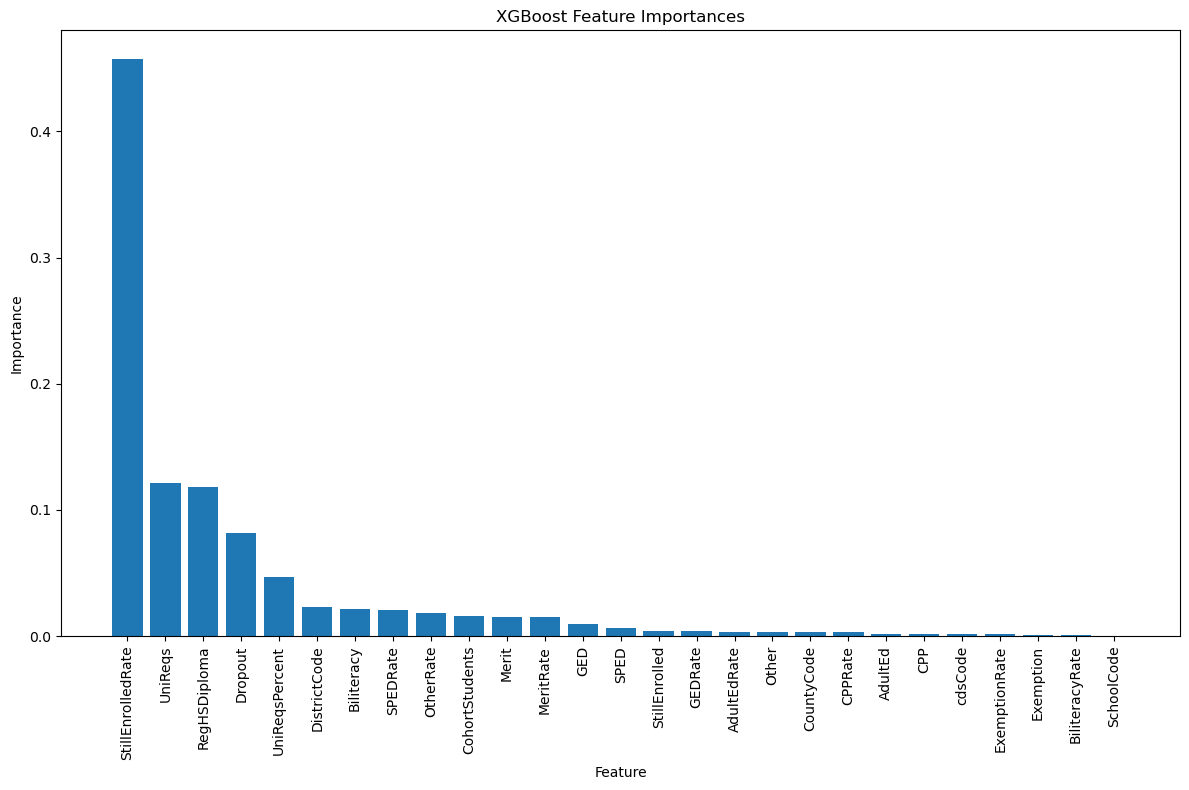

In [27]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# Proceed with XGBoost training
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)


# Fit the model
xgb_regressor.fit(X, y)

# Get feature importances
importances = xgb_regressor.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

### XGBoost Model Validation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)


# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = xgb_regressor.score(X_test, y_test)

print(f"XGBoost R^2 Score: {r_2}")
print(f"XGBoost Mean Squared Error: {mse}")
print(f"XGBoost Root Mean Squared Error: {rmse}")
print(f"XGBoost Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

XGBoost R^2 Score: 0.9949570727143461
XGBoost Mean Squared Error: 2.2119353978091
XGBoost Root Mean Squared Error: 1.4872576770045935
XGBoost Mean Absolute Error: 0.79569603639759


### XGBoost Residuals & Actual vs. Predicted

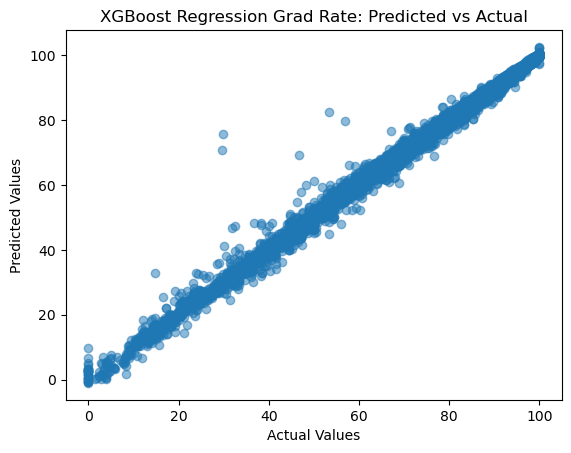

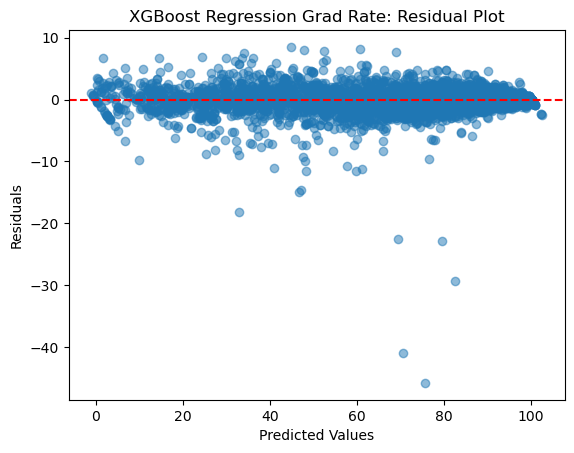

In [29]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression Grad Rate: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression Grad Rate: Residual Plot")
plt.show()

### Lasso Model for CSU/UC Rate




MeritRate: 13.09689462807375
BiliteracyRate: 6.6795546218663295
RegHSDiplomaRate: 4.351287233172538
ExemptionRate: -2.21183608543383
OtherRate: -1.8280801701090053
DropoutRate: -1.562692359098355
cdsCode: -0.7545840703908515
DistrictCode: -0.7478666851187059
SchoolCode: -0.5331867688800843
Dropout: 0.3047194681784399
StillEnrolled: 0.27694831787034685
Exemption: -0.25636655568688266
CohortStudents: 0.14977272639986028
SPEDRate: -0.13423623043259234
GEDRate: -0.13106901149423586
CPPRate: 0.0368398530166502
AdultEd: 0.0
AdultEdRate: -0.0
Biliteracy: 0.0
CPP: 0.0
CountyCode: -0.0
GED: 0.0
Merit: -0.0
Other: 0.0
RegHSDiploma: 0.0
SPED: -0.0
StillEnrolledRate: 0.0


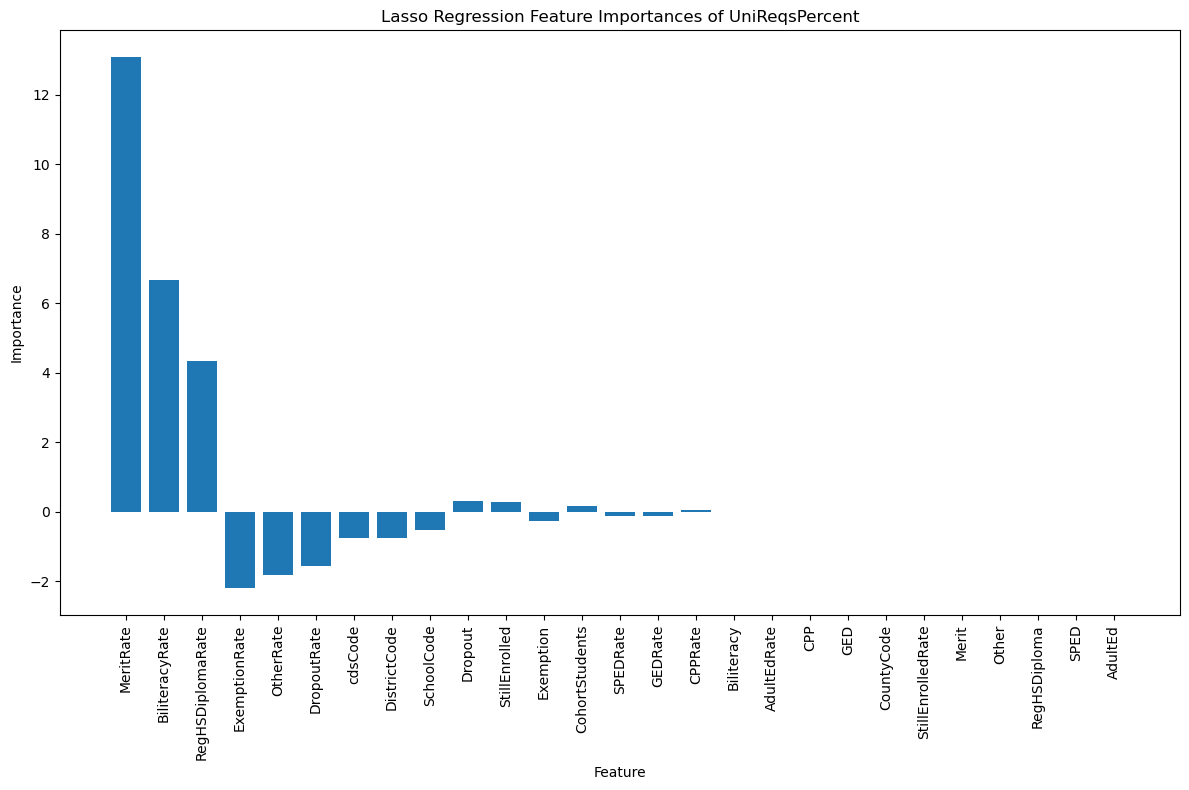

In [30]:
# Lasso Regression for UniReqsPercent as target variable

df = pd.read_sql_query("SELECT * FROM ACGR", con)
df.replace('*', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Convert categorical variables to dummy variables
categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define the target variable
target_column = 'UniReqsPercent'

# Convert the target column to numeric, coercing errors to NaN
df[target_column] = pd.to_numeric(df[target_column], errors='coerce')


# Define numeric features
numeric_features = df.columns.difference(categorical_cols).tolist()

# Drop rows with NaN values in the target column or features
df_encoded.dropna(subset=numeric_features + [target_column], inplace=True)

# Drop rows with NaN values in the categorical columns after encoding
df_encoded.dropna(inplace=True)

numeric_features = df_encoded.columns.difference(categorical_cols + [target_column, "UniReqs"]).tolist()

X = df_encoded[numeric_features]
y = df_encoded[target_column]

pipe_uni = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

pipe_uni.fit(X, y)

# Get the coefficients of the Lasso model
lasso_coefficients_uni = pipe_uni['lasso'].coef_

# Print features and coefficients sorted by absolute value of coefficient (highest first)
coef_feature_pairs_uni = list(zip(X.columns, lasso_coefficients_uni))
sorted_pairs_uni = sorted(coef_feature_pairs_uni, key=lambda x: abs(x[1]), reverse=True)
print()

for feature, coef in sorted_pairs_uni:
    print(f"{feature}: {coef}")

# Plot feature importances for UniReqsPercent Lasso
sorted_idx_uni = np.argsort(np.abs(lasso_coefficients_uni))[::-1]
plt.figure(figsize=(12, 8))
plt.bar(range(len(lasso_coefficients_uni)), lasso_coefficients_uni[sorted_idx_uni], align='center')
plt.xticks(range(len(lasso_coefficients_uni)), X.columns[sorted_idx_uni], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Lasso Regression Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### Lasso CSU/UC Percent Model Validation

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_uni.fit(X_train, y_train)

y_pred = pipe_uni.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe_uni.score(X_test, y_test)
print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.5734474097396287
Mean Squared Error: 366.85338064325265
Root Mean Squared Error: 19.15341694432752
Best alpha value: 0.01366823639488446


### Residuals and Predicted vs. Actual

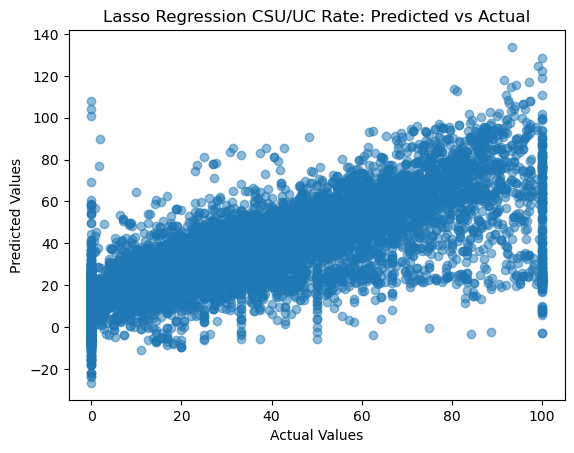

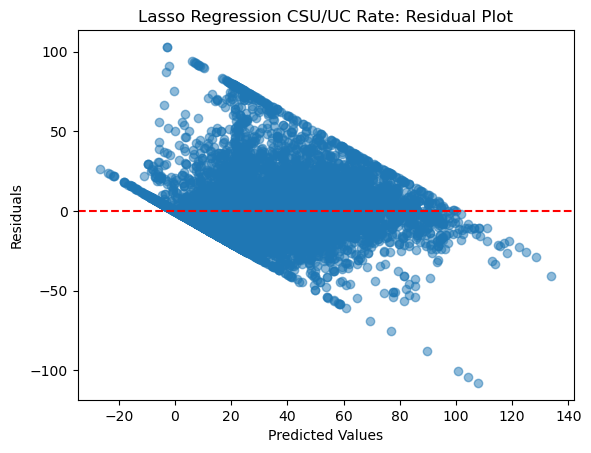

In [32]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression CSU/UC Rate: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression CSU/UC Rate: Residual Plot")
plt.show()

### XGBoost for CSU/UC Rate

Feature ranking:
1. RegHSDiplomaRate (0.2983661890029907)
2. MeritRate (0.24629755318164825)
3. BiliteracyRate (0.07600189745426178)
4. Merit (0.0513944998383522)
5. OtherRate (0.03170569986104965)
6. Biliteracy (0.031154567375779152)
7. DropoutRate (0.027243029326200485)
8. cdsCode (0.027066897600889206)
9. CountyCode (0.02291477471590042)
10. SchoolCode (0.022246209904551506)
11. DistrictCode (0.020649004727602005)
12. GEDRate (0.019813239574432373)
13. RegHSDiploma (0.019758569076657295)
14. Dropout (0.01540526282042265)
15. CohortStudents (0.01254719216376543)
16. AdultEdRate (0.011162939481437206)
17. StillEnrolled (0.01007030624896288)
18. AdultEd (0.008333860896527767)
19. GED (0.008142780512571335)
20. StillEnrolledRate (0.007581772282719612)
21. ExemptionRate (0.006501126568764448)
22. Exemption (0.006500421557575464)
23. Other (0.005666883196681738)
24. SPEDRate (0.004533897154033184)
25. CPP (0.003132504876703024)
26. SPED (0.0029344616923481226)
27. CPPRate (0.0028745087329

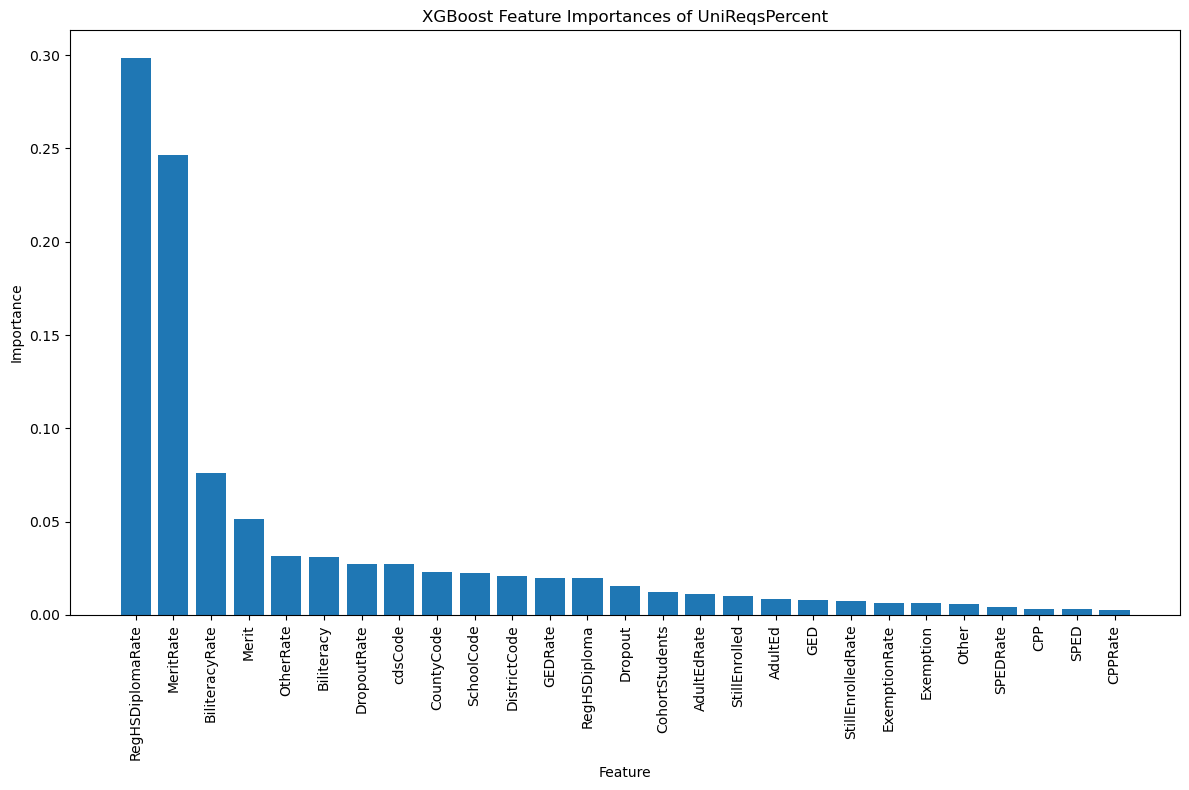

In [33]:
df_uni = pd.read_sql_query("SELECT * FROM ACGR", con)

# Count missing values for each column
df_uni.replace('*', np.nan, inplace=True)

df_uni = df_uni.apply(pd.to_numeric, errors='coerce')

target_col = 'UniReqsPercent'

df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.dropna(subset=[target_col], inplace=True)

X = df_encoded.drop(columns=[target_col, "UniReqs"])
y = df_encoded[target_col]

# XGBoost for UniReqsPercent as target variable
xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

# Fit the model
xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]
print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot feature importances for UniReqsPercent
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_names_uni)), importances_uni[indices_uni], align='center')
plt.xticks(range(len(feature_names_uni)), feature_names_uni[indices_uni], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### XGBoost CSU/UC Rate Model Validation

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 231.9457829651576
Root Mean Squared Error: 15.22976634637438
Mean Absolute Error: 10.485493415521331
R^2 Score: 0.7385146856942761


### XGBoost CSU/UC Rate Residuals vs. Actual

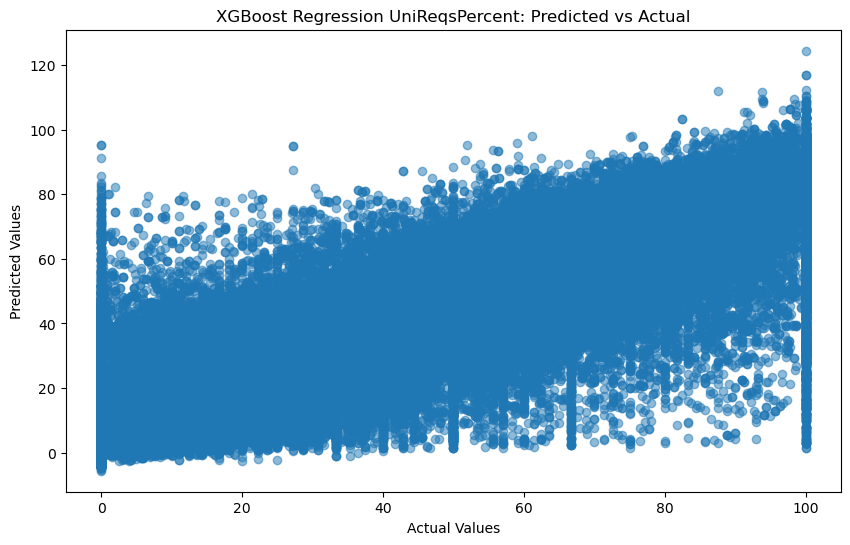

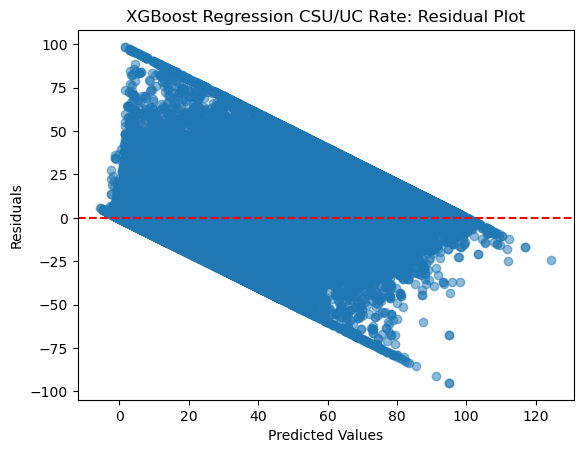

In [35]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression UniReqsPercent: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression CSU/UC Rate: Residual Plot")
plt.show()

In [36]:
con.close()